In [1]:
from evoman.environment import Environment
from demo_controller import player_controller

import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import stats
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.6.0 (SDL 2.28.4, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## box plot

In [2]:
def find_best_solution(enemy_group, method):
    print(f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt')
    file_name = f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt'
    best_files = glob.glob(file_name)
    best_fitness = -np.inf
    best_solution = None

    for file in best_files:
        sol = np.loadtxt(file)
        fitness, _, _, _ = env.play(sol)
        
        if fitness > best_fitness:
            best_solution = sol

    return best_solution


In [3]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                multiplemode="yes",
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)

results = {}
method_list = ['GA1', 'GA2']
enemy_groups = ['1_3_4_6', '2_5_7_8']


for enemy_group in enemy_groups:
    for method in method_list:
        
        env.update_parameter('enemies', [1,2,3,4,5,6,7,8])
        sol = find_best_solution(enemy_group, method)
        individual_gain_list = []
        for i in range(10):
            
            _, player_life, enemy_life, _=env.play(sol)
            indivdual_gain=player_life-enemy_life
            individual_gain_list.append(indivdual_gain)
        results[(enemy_group, method)] = individual_gain_list

experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA2_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA2_*/best.txt


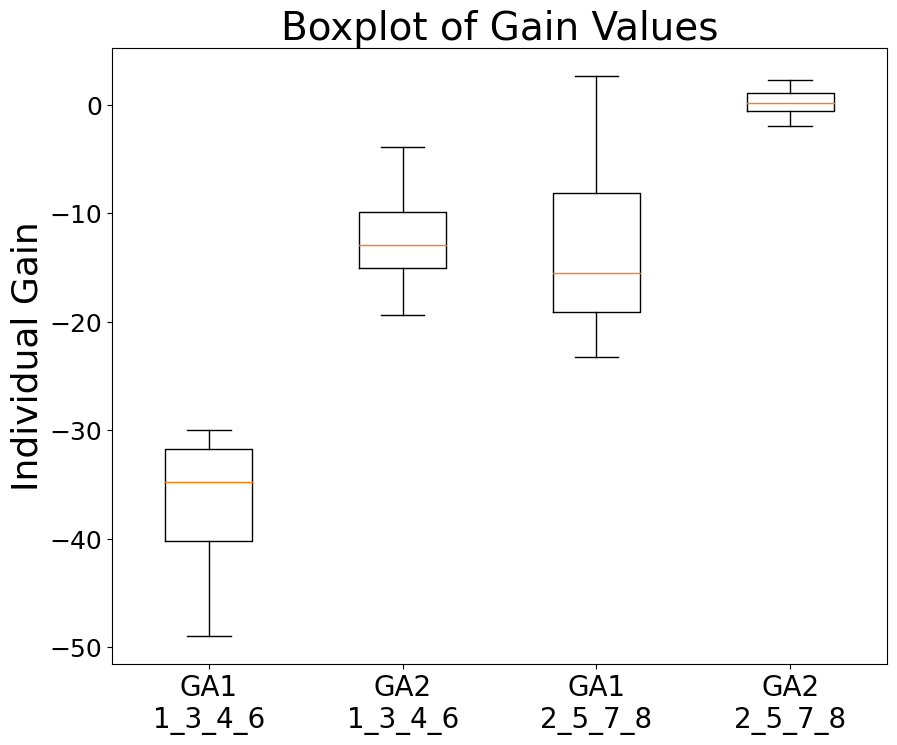

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
data = [results[key] for key in sorted(results.keys())]
labels = [f"{e}\n{m}" for m, e in sorted(results.keys())]

ax.boxplot(data, labels=labels)
ax.set_title('Boxplot of Gain Values', fontsize=28)
ax.set_ylabel('Individual Gain', fontsize=26)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=18)
# plt.xticks(rotation=45)
plt.savefig("box_plot_2.png", dpi=150)

In [5]:
# Mann-Whitney U test
alpha = 0.05
mannwhitney_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    u_stat, p_value = stats.mannwhitneyu(ga_results, es_results, alternative='two-sided')
    mannwhitney_results[enemy_group] = {'u_stat': u_stat, 'p_value': p_value}


for enemy_group, res in mannwhitney_results.items():
    print(f"Enemy {enemy_group} - U statistic: {res['u_stat']:.3f}, p-value: {res['p_value']:.3e}")
    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - U statistic: 0.000, p-value: 1.817e-04
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - U statistic: 0.000, p-value: 1.827e-04
For Enemy 2_5_7_8, the difference between GA and ES is statistically significant.


In [6]:
# t-test
ttest_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    t_stat, p_value = stats.ttest_ind(ga_results, es_results, equal_var=False)
    ttest_results[enemy_group] = {'t_stat': t_stat, 'p_value': p_value}

for enemy_group, res in ttest_results.items():
    print(f"Enemy {enemy_group} - t-statistic: {res['t_stat']:.3f}, p-value: {res['p_value']:.3e}")
    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - t-statistic: -12.812, p-value: 4.360e-10
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - t-statistic: -9.837, p-value: 1.231e-06
For Enemy 2_5_7_8, the difference between GA and ES is statistically significant.


In [7]:
# Kolmogorov-Smirnov test
ks_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    ks_stat, p_value = stats.ks_2samp(ga_results, es_results)
    ks_results[enemy_group] = {'ks_stat': ks_stat, 'p_value': p_value}

for enemy_group, res in ks_results.items():
    print(f"Enemy {enemy_group} - KS statistic: {res['ks_stat']:.3f}, p-value: {res['p_value']:.3e}")

Enemy 1_3_4_6 - KS statistic: 1.000, p-value: 1.083e-05
Enemy 2_5_7_8 - KS statistic: 1.000, p-value: 1.083e-05


In [8]:
# Kruskal-Wallis H test
kruskal_results = {}

for enemy_group in enemy_groups:
    ga_results = results[(enemy_group, 'GA1')]
    es_results = results[(enemy_group, 'GA2')]

    h_stat, p_value = stats.kruskal(ga_results, es_results)  
    kruskal_results[enemy_group] = {'h_stat': h_stat, 'p_value': p_value}

for enemy_group, res in kruskal_results.items():
    print(f"Enemy {enemy_group} - H statistic: {res['h_stat']:.3f}, p-value: {res['p_value']:.3e}")

    if res['p_value'] < alpha:
        print(f"For Enemy {enemy_group}, the difference between GA and ES is statistically significant.")
    else:
        print(f"For Enemy {enemy_group}, no significant difference was found.")

Enemy 1_3_4_6 - H statistic: 14.296, p-value: 1.562e-04
For Enemy 1_3_4_6, the difference between GA and ES is statistically significant.
Enemy 2_5_7_8 - H statistic: 14.286, p-value: 1.571e-04
For Enemy 2_5_7_8, the difference between GA and ES is statistically significant.


## Very Best

In [9]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                multiplemode="yes",
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)

results = {}
method_list = ['GA1', 'GA2']
enemy_groups = ['1_3_4_6', '2_5_7_8']

best_fitness = -np.inf
best_solution = None
best_file_name = None

for enemy_group in enemy_groups:
    for method in method_list:
        print(f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt')
        file_name = f'experiments_train_generalist_{enemy_group}/optimization_generalist_generalist_{method}_*'+'/best.txt'
        best_files = glob.glob(file_name)   
        
        for file in best_files:
            sol = np.loadtxt(file)
            env.update_parameter('enemies', [1,2,3,4,5,6,7,8])
            fitness, _, _, _ = env.play(sol)
        
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = sol
                best_file_name = file

experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA2_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA1_*/best.txt
experiments_train_generalist_2_5_7_8/optimization_generalist_generalist_GA2_*/best.txt


In [10]:
print(best_file_name)

experiments_train_generalist_1_3_4_6/optimization_generalist_generalist_GA1_20241017-182533/best.txt


In [11]:
n_hidden_neurons = 10

env = Environment(experiment_name='best_experiment_test',
                playermode="ai",
				player_controller=player_controller(n_hidden_neurons),
				speed="fastest",
				enemymode="static",
                logs="off",
                randomini="yes",
				level=2,
				visuals=True)

individual_gain_list = []
for i in range(1,9):
    
    env.update_parameter('enemies', [i])
    _, player_life, enemy_life, _ = env.play(best_solution)
    individual_gain = int(player_life - enemy_life)
    individual_gain_list.append(individual_gain)
print(individual_gain_list)

[-20, -30, -30, 34, 79, -50, -60, -70]
